In [166]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import lightgbm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Train

In [167]:
cols = ['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time',
        'prior_question_had_explanation']
train = pd.read_pickle("/content/drive/MyDrive/riiid_train.pkl.gzip")[cols]

## Train Test Split

In [168]:
test = train.groupby('user_id').tail(5)
train.drop(test.index, inplace=True)

In [169]:
train = train.rename(columns={'prior_question_elapsed_time': 'prior_time'})
train = train.rename(columns={'prior_question_had_explanation': 'prior_saw_explanation'})
train.prior_saw_explanation = train.prior_saw_explanation.astype('boolean')

# prior_saw_explanation is none when prior_time is nan, so user hasn't seen prior explanation
train.prior_saw_explanation.fillna(False, inplace=True)
train.prior_saw_explanation = train.prior_saw_explanation.astype('int8')


# Feature Dataframes

## df_user (using train_latest)

In [170]:
train_latest = train.groupby('user_id').tail(100)
# train_latest = train.copy()

### df_user_lec

In [172]:
df_lec = pd.read_csv('/content/drive/MyDrive/lectures.csv')
df_lec.drop(columns='tag', inplace=True)
df_lec.columns=['lec_id', 'user_part', 'user_type']
df_lec = pd.get_dummies(df_lec, columns=['user_part', 'user_type'])
df_lec.head()

,lec_id,user_part_1,user_part_2,user_part_3,user_part_4,user_part_5,user_part_6,user_part_7,user_type_concept,user_type_intention,user_type_solving question,user_type_starter
0,89,0,0,0,0,1,0,0,1,0,0,0
1,100,1,0,0,0,0,0,0,1,0,0,0
2,185,0,0,0,0,0,1,0,1,0,0,0
3,192,0,0,0,0,1,0,0,0,0,1,0
4,317,0,0,0,0,1,0,0,0,0,1,0


In [173]:
tmp = train_latest.loc[train_latest.answered_correctly == -1 ,['user_id', 'content_id']]
tmp = tmp.merge(df_lec, left_on='content_id', right_on='lec_id')

In [174]:
parts = [column for column in df_lec if column.startswith('user_part')]
types = [column for column in df_lec if column.startswith('user_type')]
df_user_lec = tmp.groupby('user_id')[parts + types].sum().reset_index()

In [175]:
del tmp
del df_lec

#### Drop lectures

In [176]:
train = train[train.answered_correctly != -1]
train = train.rename(columns={'content_id': 'question_id'})
train.shape

(97330440, 5)

### df_user_question

In [177]:
df_user_question = train_latest.groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
df_user_question.columns = ['user_id', 'user_times_answered', 'user_accuracy']
df_user_question.shape

(393382, 3)

### df_user_sees_explanatation

In [178]:
df_user_sees_explanation = train_latest.groupby('user_id').agg({'prior_saw_explanation': ['mean']}).reset_index()
df_user_sees_explanation.columns=['user_id', 'user_sees_explanation']

### df_user_avg_time

In [179]:
df_user_avg_time = train_latest.groupby('user_id').agg({'prior_time': ['mean']}).reset_index()
df_user_avg_time.columns=['user_id', 'user_avg_time']
df_user_avg_time.head()

,user_id,user_avg_time
0,115,20500.000000
1,124,21333.208984
2,2746,18307.691406
3,5382,36469.386719
4,8623,26191.751953


### df_user (combined)

In [180]:
df_user = df_user_lec.merge(df_user_question, on='user_id', how='outer')
df_user.shape # we will see that df_user_question is inclusive of df_user_lec

df_user[df_user.user_id==115]

,user_id,user_part_1,user_part_2,user_part_3,user_part_4,user_part_5,user_part_6,user_part_7,user_type_concept,user_type_intention,user_type_solving question,user_type_starter,user_times_answered,user_accuracy
118621,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,0.731707


In [181]:
# Since nan comes from df_user_lec being smaller, fill using df_user_lec
for col in df_user_lec.columns[1:]:
  val_fill = df_user_lec[col].mean()
  df_user[col].fillna(val_fill, inplace=True)
df_user[df_user.user_id==115]

,user_id,user_part_1,user_part_2,user_part_3,user_part_4,user_part_5,user_part_6,user_part_7,user_type_concept,user_type_intention,user_type_solving question,user_type_starter,user_times_answered,user_accuracy
118621,115,0.233778,0.649261,0.093795,0.087708,1.322506,0.217356,0.0631,2.009509,0.217112,0.440866,0.000017,41,0.731707


In [182]:
df_user = df_user.merge(df_user_sees_explanation, on='user_id', how='left')
df_user = df_user.merge(df_user_avg_time, on='user_id', how='left')

In [183]:
df_user.user_id = df_user.user_id.astype('int32')
cols_float16 = df_user.columns[1:-1]
df_user[cols_float16] = df_user[cols_float16].astype('float16')

In [184]:
del train_latest

## df_question

In [185]:
df_question = train.groupby('question_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
df_question.columns = ['question_id', 'question_times_asked', 'question_accuracy']


In [186]:
train['time'] = train[['prior_time']].shift(periods=-1, axis='rows')
train['saw_explanation'] = train[['prior_saw_explanation']].shift(periods=-1, axis='rows')

In [187]:
tmp = train.groupby('question_id').agg({'time': 'mean'})
tmp.columns = ['question_time']

train.drop(columns=['time'], inplace=True)

In [188]:
df_question = df_question.merge(tmp, on='question_id')
del tmp
df_question.head()

,question_id,question_times_asked,question_accuracy,question_time
0,0,6843,0.907789,19695.111328
1,1,7334,0.891055,19317.537109
2,2,44342,0.555162,24580.992188
3,3,22696,0.780534,21610.310547
4,4,31514,0.613918,22041.882812


In [189]:
tmp = train.groupby('question_id').agg({'saw_explanation': 'mean'})
tmp.columns = ['question_saw_explanation']

train.drop(columns=['saw_explanation'], inplace=True)

In [190]:
df_question = df_question.merge(tmp, on='question_id')
del tmp

In [191]:
tmp = train[['question_id', 'user_id']].groupby(['question_id',]).agg('nunique')
tmp.columns = ['question_times_asked_by_unique_users']

In [192]:
df_question = df_question.merge(tmp, on='question_id')
del tmp
df_question['question_times_asked_per_user'] = \
  df_question['question_times_asked'] / df_question['question_times_asked_by_unique_users']

In [193]:
df_question.question_id = df_question.question_id.astype('int16')
df_question.question_times_asked = df_question.question_times_asked.astype('int32')
df_question.question_accuracy = df_question.question_accuracy.astype('float16')
df_question.question_saw_explanation = df_question.question_saw_explanation.astype('float16')
df_question.question_times_asked_by_unique_users = df_question.question_times_asked_by_unique_users.astype('int32')
df_question.question_times_asked_per_user = df_question.question_times_asked_per_user.astype('float16')


## df_tags

In [194]:
df_tags = pd.read_csv('/content/drive/MyDrive/questions.csv')[['question_id', 'part', 'tags']]
df_tags['tags'] = df_tags['tags'].astype(str)
lst_tags = [x.split() for x in df_tags.tags.values]
maxi = 6
arr_tags = []
for tags in lst_tags:
  len_pad = maxi - len(tags)
  if tags[0] == 'nan':
    tags[0] = 0
  tags = np.array(tags, dtype=int)
  tags = np.pad(tags, (0, len_pad))
  arr_tags.append(tags)
arr_tags = np.stack(arr_tags)
df_tags['tag0'] = arr_tags[:, 0]
df_tags['tag1'] = arr_tags[:, 1]
df_tags['tag2'] = arr_tags[:, 2]
df_tags['tag3'] = arr_tags[:, 3]
df_tags['tag4'] = arr_tags[:, 4]
df_tags['tag5'] = arr_tags[:, 5]
df_tags.drop(columns=['tags'], inplace=True)

In [195]:
df_tags.question_id = df_tags.question_id.astype('int16')
df_tags.part = df_tags.part.astype('int8')
cols_uint8 = df_tags.columns[2:]
df_tags[cols_uint8] = df_tags[cols_uint8].astype('uint8')

## df_part

In [196]:
tmp = train[['question_id', 'answered_correctly']]\
  .merge(df_tags[['question_id', 'part']], on='question_id', how='left')
df_part = tmp.groupby('part').agg({'answered_correctly': ['count', 'mean']}).reset_index()
df_part.columns = ['part', 'part_times_asked', 'part_accuracy']

In [197]:
del tmp

In [198]:
df_part.part = df_part.part.astype('int8')
df_part.part_times_asked = df_part.part_times_asked.astype('int32')
df_part.part_accuracy = df_part.part_accuracy.astype('float16')

# Merge on user_id (for fillnas)

In [199]:
%%time
train = train.merge(df_user, on = "user_id", how = "left")

CPU times: user 12.4 s, sys: 86 ms, total: 12.5 s
Wall time: 12.5 s


# Fillnas (on whole data)

In [200]:
num_examples = train.shape[0]
num_users = df_user_question.shape[0]

In [201]:
fillnas = {}
for col in df_user_lec.columns[1:]:
  fillnas[col] = train[col].astype('float64').mean()

#df_user_question
fillnas['user_times_answered'] =  num_examples / num_users
fillnas['user_accuracy'] = train.answered_correctly.astype('int64').mean()
fillnas['user_sees_explanation'] = train.user_sees_explanation.astype('float64').mean()
fillnas['user_avg_time'] = train.prior_time.astype('float64').mean()

fillnas['prior_time'] = train['prior_time'].astype('float64').mean()

fillnas

{'prior_time': 25446.638436913097,
 'user_accuracy': 0.6595619725956238,
 'user_avg_time': 25446.638436913097,
 'user_part_1': 0.22794398052699594,
 'user_part_2': 0.5915571448998093,
 'user_part_3': 0.11800924109207875,
 'user_part_4': 0.12533837850468527,
 'user_part_5': 1.4647460082045953,
 'user_part_6': 0.30421124093830954,
 'user_part_7': 0.09453243990863552,
 'user_sees_explanation': 0.9126475309070861,
 'user_times_answered': 247.4196582456747,
 'user_type_concept': 2.0583891383753827,
 'user_type_intention': 0.17125400460780058,
 'user_type_solving question': 0.6968521533217553,
 'user_type_starter': 2.2282542734481287e-05}

# Decrease train size

In [202]:
# By sampling
# train = train.sample(n=21810401, random_state = 1)

# By getting most recent examples
train = train.groupby('user_id').tail(100)
train.shape


(20733489, 20)

## Drop user_id (Train)

In [203]:
train.drop(columns='user_id', inplace=True)

# Merge on question_id, part

In [204]:
%%time
train = train.merge(df_question, on = "question_id", how = "left")
train = train.merge(df_tags, on = "question_id", how = "left")
train = train.merge(df_part, on = "part", how = "left")

CPU times: user 13.4 s, sys: 183 ms, total: 13.5 s
Wall time: 13.5 s


## Drop question_id (Train)

In [205]:
train.drop(columns='question_id', inplace=True)

# Test set

In [206]:
test = test[test.answered_correctly != -1]

test = test.rename(columns={'prior_question_elapsed_time': 'prior_time'})
test = test.rename(columns={'prior_question_had_explanation': 'prior_saw_explanation'})
test = test.rename(columns={'content_id': 'question_id'})

# prior_saw_explanation is none when prior_time is nan, so user hasn't seen prior explanation
test.prior_saw_explanation = test.prior_saw_explanation.astype('boolean')
test.prior_saw_explanation.fillna(False, inplace=True)
test.prior_saw_explanation = test.prior_saw_explanation.astype('int8')


In [207]:
test = test.merge(df_user, on = "user_id", how = "left")
test = test.merge(df_question, on = "question_id", how = "left")
test = test.merge(df_tags, on = "question_id", how = "left")
test = test.merge(df_part, on = "part", how = "left")

## Drop question_id, user_id (Test)

In [208]:
test.drop(columns='question_id', inplace=True)   
test.drop(columns='user_id', inplace=True)

In [209]:
for col in train.columns:
  test[col] = test[col].astype(train[col].dtype)

## Fillna

In [210]:
test['prior_time'].fillna(fillnas['prior_time'], inplace = True)

test['user_times_answered'].fillna(fillnas['user_times_answered'], inplace = True)
test['user_accuracy'].fillna(fillnas['user_accuracy'], inplace = True)
test['user_sees_explanation'].fillna(fillnas['user_sees_explanation'], inplace = True)
test['user_avg_time'].fillna(fillnas['user_avg_time'], inplace = True)

test.dtypes

answered_correctly                         int8
prior_time                              float32
prior_saw_explanation                      int8
user_part_1                             float16
user_part_2                             float16
user_part_3                             float16
user_part_4                             float16
user_part_5                             float16
user_part_6                             float16
user_part_7                             float16
user_type_concept                       float16
user_type_intention                     float16
user_type_solving question              float16
user_type_starter                       float16
user_times_answered                     float16
user_accuracy                           float16
user_sees_explanation                   float16
user_avg_time                           float32
question_times_asked                      int32
question_accuracy                       float16
question_time                           

# Features

In [211]:
# Casting as category is hurting accuracy
# train[['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'part']] = \
#   train[['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5','part']].astype('category')
# val[['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'part']] = \
#   val[['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5','part']].astype('category')

In [212]:
features = [
# "given"
  'prior_time', 
  'prior_saw_explanation',

# "df_user"
  'user_part_1', 'user_part_2','user_part_3', 'user_part_4', 'user_part_5', 'user_part_6','user_part_7',
  'user_type_concept', 
  'user_type_intention',
  'user_type_solving question', 
  'user_type_starter', 
  'user_times_answered', 
  'user_accuracy', 
  'user_avg_time',
  'user_sees_explanation',

# "df_part"
  'part', 
  'part_times_asked', 
  'part_accuracy', 

# "df_question"
  #'question_id', #useless (confirmed twice)
  'question_times_asked',
  'question_accuracy', 
  'question_times_asked_per_user',
  'question_times_asked_by_unique_users',
  'question_saw_explanation',
  'question_time',

# "df_tags"
  'tag0', 'tag1', 'tag2', 'tag3', 'tag4','tag5', 
  ]

# Light Gradient Boosting

In [213]:
ds_train = lightgbm.Dataset(train[features], train['answered_correctly'])
ds_test = lightgbm.Dataset(test[features], test['answered_correctly'])

params = {
    'objective': 'binary',
    'metric': 'auc', # roc_auc
    'seed': 2020,
    }

In [214]:
%%time
model = lightgbm.train(
    params=params, 
    train_set=ds_train,
    valid_sets=[ds_test],
    verbose_eval=50,
    num_boost_round=50000,
    early_stopping_rounds=8
)

Training until validation scores don't improve for 8 rounds.
[50]	valid_0's auc: 0.725793
[100]	valid_0's auc: 0.727065
[150]	valid_0's auc: 0.727675
Early stopping, best iteration is:
[169]	valid_0's auc: 0.727843
CPU times: user 1h 9min 21s, sys: 1.28 s, total: 1h 9min 22s
Wall time: 2min 21s


In [215]:
# tpu 149, gpu 324, cpu 290
#kaggle 345

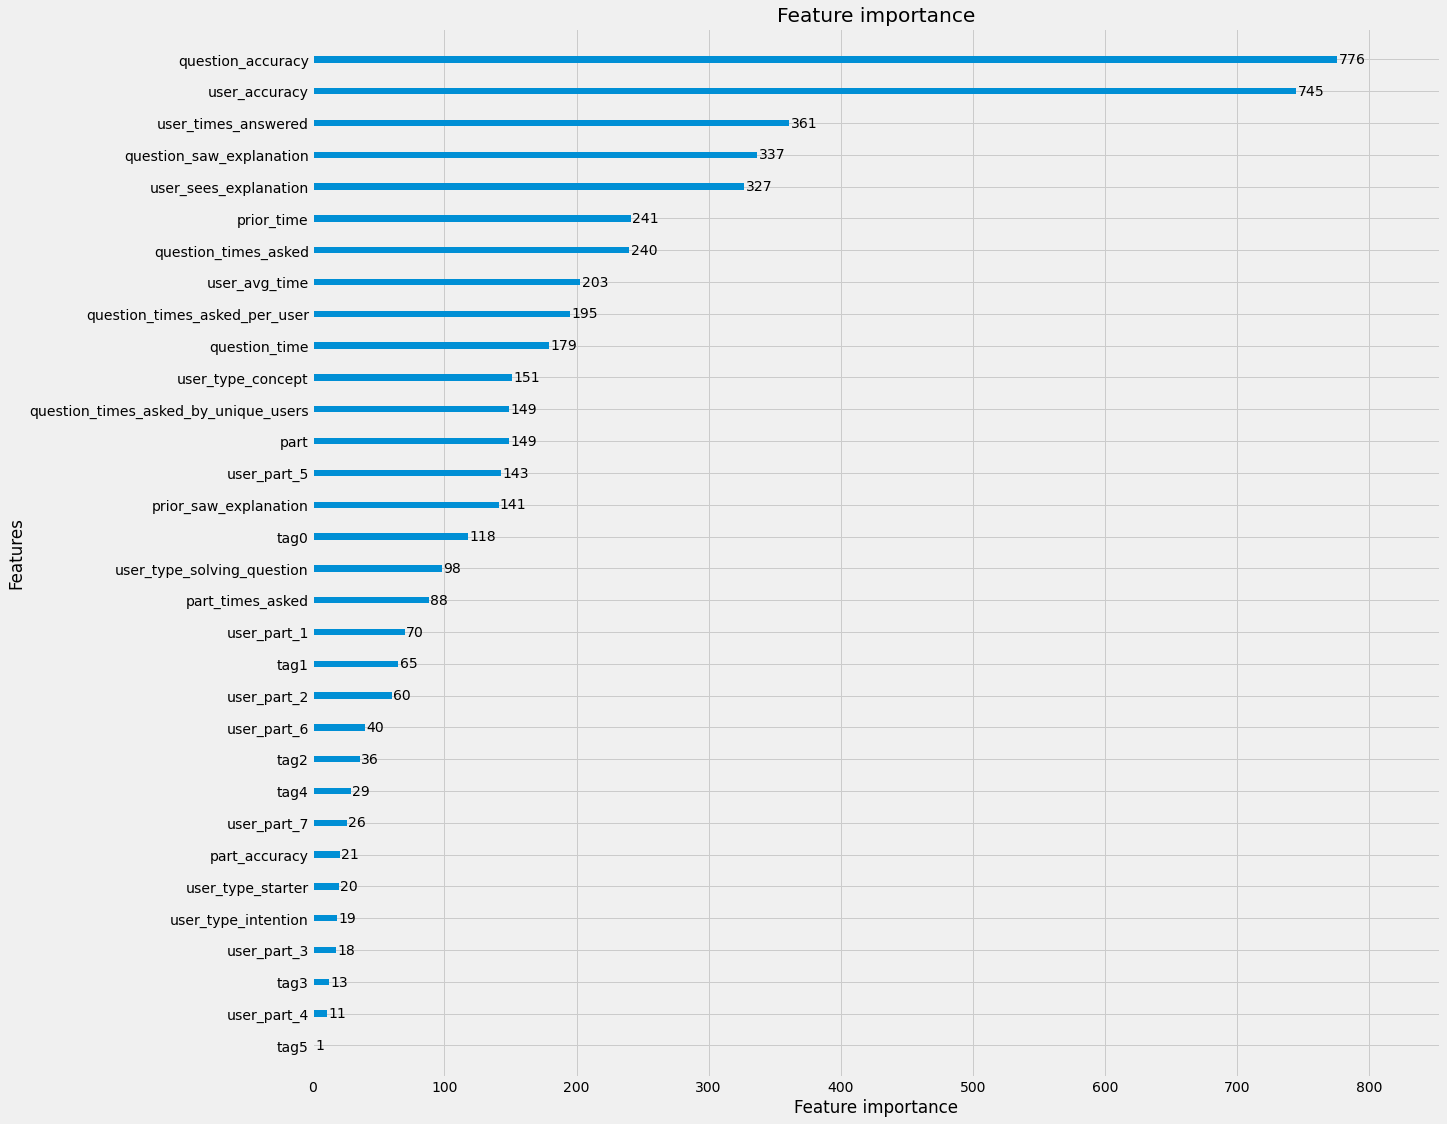

In [216]:
#Plot
lightgbm.plot_importance(model, figsize=(18,18))
plt.show()

In [217]:
# #Scores using sklearn.metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score

# preds = model.predict(val)
# print(preds)
# for el in preds:
#   if el > 1 or el < -1:
#     throw
# score_roc_auc = roc_auc_score(y_val, preds)
# print(f'ROC AUC: {score_roc_auc}')

# preds[preds>0.5] = 1
# preds[preds<0.5] = 0
# score_acc = accuracy_score(y_val, preds)
# print(f'Accuracy: {score_acc}')

In [218]:
# import riiideducation
# env = riiideducation.make_env()
# iter_test = env.iter_test()
# for (test_df, sample_prediction_df) in iter_test:
#     test = test_df[['row_id', 'user_id',  'content_id', 'prior_question_elapsed_time',
#         'prior_question_had_explanation']]

#     test = test[test.answered_correctly != -1]

#     test = test.rename(columns={'prior_question_elapsed_time': 'prior_time'})
#     test = test.rename(columns={'prior_question_had_explanation': 'prior_saw_explanation'})
#     test = test.rename(columns={'content_id': 'question_id'})

#     # prior_saw_explanation is none when prior_time is nan, so user hasn't seen prior explanation
#     test.prior_saw_explanation = test.prior_saw_explanation.astype('boolean')
#     test.prior_saw_explanation.fillna(False, inplace=True)
#     test.prior_saw_explanation = test.prior_saw_explanation.astype('int8')

#     test = test.merge(df_user, on = "user_id", how = "left")
#     test = test.merge(df_question, on = "question_id", how = "left")
#     test = test.merge(df_tags, on = "question_id", how = "left")
#     test = test.merge(df_part, on = "part", how = "left")

#     test.drop(columns='question_id', inplace=True)   
#     test.drop(columns='user_id', inplace=True)

#     for col in train.columns:
#       test[col] = test[col].astype(train[col].dtype)
#     test['prior_time'].fillna(fillnas['prior_time'], inplace = True)

#     test['user_times_answered'].fillna(fillnas['user_times_answered'], inplace = True)
#     test['user_accuracy'].fillna(fillnas['user_accuracy'], inplace = True)
#     test['user_sees_explanation'].fillna(fillnas['user_sees_explanation'], inplace = True)
#     test['user_avg_time'].fillna(fillnas['user_avg_time'], inplace = True)
    
#     test['answered_correctly'] = model.predict(tmp[features])
#     env.predict(test[['row_id', 'answered_correctly']])
#     del test